# 1. Import and setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

from scipy.stats import pearsonr, ttest_ind
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Setting up styling
sns.set(style="darkgrid")
sns.set_palette("flare")

print(sns.color_palette("flare").as_hex())
palette = sns.color_palette("flare").as_hex()
sns.color_palette("flare")

['#e98d6b', '#e3685c', '#d14a61', '#b13c6c', '#8f3371', '#6c2b6d']


[(0.9155979, 0.55210684, 0.42070204),
 (0.888292, 0.40830288, 0.36223756),
 (0.81942908, 0.28911553, 0.38102921),
 (0.69226314, 0.23413578, 0.42480327),
 (0.56041794, 0.19845221, 0.44207535),
 (0.42355299, 0.16934709, 0.42581586)]

In [3]:
RANDOM_STATE=42

# 2. Read dataset

In [4]:
df = pd.read_csv('../dataset/icd_cohort.csv', index_col=0)
df.head()

,hadm_id,alcoholism,gender,anchor_age,deathtime,hematocrit_serum,c_creative_protein,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,lactate_dehydrogenase_LDH,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,earliest_height_cm
0,22317773,0,F,35,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,22871498,0,F,40,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29651132,0,F,40,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22540021,1,F,46,NaN,36.4,NaN,37.0,1.2,117.0,...,220.0,9.8,20.0,0.6,220.0,20.0,140.0,60.0,78.0,170.18
4,28349150,0,F,48,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Label mortality
df['mortality'] = df['deathtime'].apply(lambda x: 'Survive' if x is np.nan else 'Dead')
df['mortality'].value_counts()

mortality
Survive    3919
Dead         98
Name: count, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4017 entries, 0 to 4016
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   hadm_id                                4017 non-null   int64  
 1   alcoholism                             4017 non-null   int64  
 2   gender                                 4017 non-null   object 
 3   anchor_age                             4017 non-null   int64  
 4   deathtime                              98 non-null     object 
 5   hematocrit_serum                       694 non-null    float64
 6   c_creative_protein                     20 non-null     float64
 7   blood_urea_nitrogen                    693 non-null    float64
 8   serum_creatinine                       693 non-null    float64
 9   Non_Invasive_Blood_Pressure_systolic   704 non-null    float64
 10  Non_Invasive_Blood_Pressure_diastolic  704 non-null    float64
 11  Serum_Amy

In [7]:
df.columns

Index(['hadm_id', 'alcoholism', 'gender', 'anchor_age', 'deathtime',
       'hematocrit_serum', 'c_creative_protein', 'blood_urea_nitrogen',
       'serum_creatinine', 'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'Serum_Amylase', 'lipase',
       'white_bloodcells', 'lactate_dehydrogenase', 'Glucose_serum',
       'platelet_PLT', 'Prothrombin_time', 'aminotransferase_ALT',
       'Total_Bilirubin', 'lactate_dehydrogenase_LDH', 'Anion_gap',
       'Heart_rate_Alarm_High', 'Heart_rate_Alarm_low', 'earliest_weight_kg',
       'earliest_height_cm', 'mortality'],
      dtype='object')

# 3. Exploratory Data

## 3.1. General Statistics

In [8]:
df.shape

(4017, 27)

In [9]:
df.isnull().sum(axis=1)

0       22
1       22
2       22
3        3
4       22
        ..
4012    22
4013    22
4014     6
4015    22
4016    22
Length: 4017, dtype: int64

There are 22 out of 27 variables of lab and chartevents, rest of them are demographic. If we want to at least have no more than 2 column with missing values, we can filter missing values no more than $\frac{2}{22}=0.091~0.1$.

In [10]:
df[df.drop(['hadm_id', 'alcoholism', 'gender', 'anchor_age', 'deathtime', 'mortality'], axis=1).isnull().sum(axis=1) / (df.shape[1]-6) <= 0.1]

,hadm_id,alcoholism,gender,anchor_age,deathtime,hematocrit_serum,c_creative_protein,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,...,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,lactate_dehydrogenase_LDH,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,earliest_height_cm,mortality
3,22540021,1,F,46,NaN,36.4,NaN,37.0,1.2,117.0,...,9.8,20.0,0.6,220.0,20.0,140.0,60.0,78.0,170.18,Survive
37,20561449,1,F,45,NaN,43.5,NaN,7.0,1.1,151.0,...,15.0,31.0,0.6,420.0,34.0,120.0,50.0,65.0,NaN,Survive
39,25384874,0,F,54,NaN,33.6,NaN,7.0,0.7,124.0,...,15.8,32.0,0.3,164.0,12.0,120.0,50.0,160.4,168.00,Survive
55,24096764,0,M,76,NaN,34.3,NaN,51.0,4.8,124.0,...,15.6,222.0,4.0,409.0,20.0,120.0,60.0,94.5,170.18,Survive
59,23237185,0,M,86,NaN,26.4,NaN,33.0,1.5,105.0,...,13.8,1896.0,2.2,1996.0,9.0,100.0,60.0,70.0,175.26,Survive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3976,25242108,1,F,39,NaN,22.3,NaN,18.0,0.5,96.0,...,34.2,36.0,17.9,185.0,8.0,120.0,50.0,93.1,NaN,Survive
3991,24542195,0,F,75,NaN,31.0,NaN,23.0,1.0,140.0,...,13.9,14.0,0.5,588.0,11.0,130.0,50.0,73.0,163.00,Survive
3997,29695232,0,M,35,NaN,37.7,NaN,22.0,1.4,81.0,...,17.7,77.0,0.8,240.0,22.0,120.0,60.0,72.0,170.18,Survive
4002,21781012,0,M,51,NaN,32.2,NaN,25.0,0.9,134.0,...,12.1,46.0,0.6,132.0,16.0,120.0,60.0,78.9,175.26,Survive


In [11]:
df_clean = df[df.drop(['hadm_id', 'alcoholism', 'gender', 'anchor_age', 'deathtime', 'mortality'], axis=1).isnull().sum(axis=1) / (df.shape[1]-6) <= 0.1]
df_clean.reset_index(inplace=True, drop=True)
df_clean

,hadm_id,alcoholism,gender,anchor_age,deathtime,hematocrit_serum,c_creative_protein,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,...,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,lactate_dehydrogenase_LDH,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,earliest_height_cm,mortality
0,22540021,1,F,46,NaN,36.4,NaN,37.0,1.2,117.0,...,9.8,20.0,0.6,220.0,20.0,140.0,60.0,78.0,170.18,Survive
1,20561449,1,F,45,NaN,43.5,NaN,7.0,1.1,151.0,...,15.0,31.0,0.6,420.0,34.0,120.0,50.0,65.0,NaN,Survive
2,25384874,0,F,54,NaN,33.6,NaN,7.0,0.7,124.0,...,15.8,32.0,0.3,164.0,12.0,120.0,50.0,160.4,168.00,Survive
3,24096764,0,M,76,NaN,34.3,NaN,51.0,4.8,124.0,...,15.6,222.0,4.0,409.0,20.0,120.0,60.0,94.5,170.18,Survive
4,23237185,0,M,86,NaN,26.4,NaN,33.0,1.5,105.0,...,13.8,1896.0,2.2,1996.0,9.0,100.0,60.0,70.0,175.26,Survive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,25242108,1,F,39,NaN,22.3,NaN,18.0,0.5,96.0,...,34.2,36.0,17.9,185.0,8.0,120.0,50.0,93.1,NaN,Survive
338,24542195,0,F,75,NaN,31.0,NaN,23.0,1.0,140.0,...,13.9,14.0,0.5,588.0,11.0,130.0,50.0,73.0,163.00,Survive
339,29695232,0,M,35,NaN,37.7,NaN,22.0,1.4,81.0,...,17.7,77.0,0.8,240.0,22.0,120.0,60.0,72.0,170.18,Survive
340,21781012,0,M,51,NaN,32.2,NaN,25.0,0.9,134.0,...,12.1,46.0,0.6,132.0,16.0,120.0,60.0,78.9,175.26,Survive


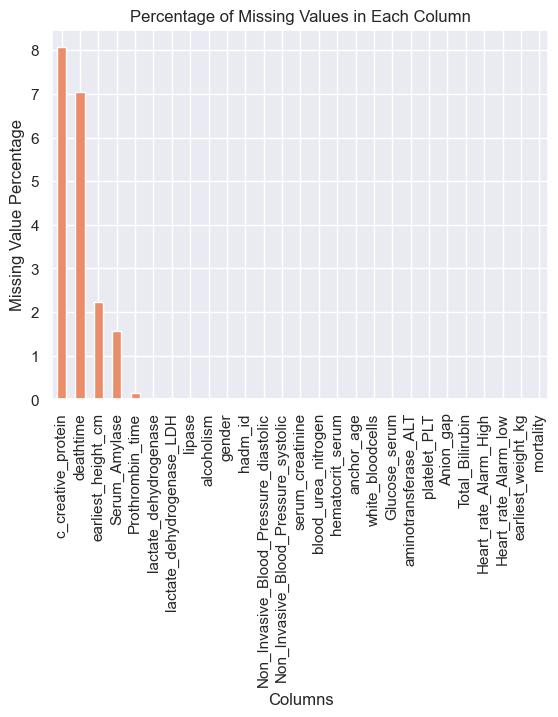

In [12]:
# Datatype and missing value information
missing_percentage = (df_clean.isnull().sum() / len(df)) * 100
    
missing_percentage.sort_values(ascending=False).plot(kind='bar', color=palette[0])
plt.xlabel('Columns')
plt.ylabel('Missing Value Percentage')
plt.title('Percentage of Missing Values in Each Column')
plt.show()

In [13]:
missing_columns = missing_percentage.sort_values(ascending=False)[:4]
missing_columns

c_creative_protein    8.065721
deathtime             7.045059
earliest_height_cm    2.240478
Serum_Amylase         1.568335
dtype: float64

In [14]:
df_clean.drop(missing_columns.index, axis=1, inplace=True)

In [15]:
# Statistical description of numerical features
df_clean.describe(include=[np.number]).round(2)

,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,lactate_dehydrogenase_LDH,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
count,342.00,342.0,342.00,342.00,342.00,342.00,342.00,342.00,341.00,342.00,...,342.00,342.00,336.00,342.00,342.00,341.00,342.00,342.00,342.00,342.00
mean,24888024.08,0.2,58.49,33.79,30.39,1.69,128.56,72.54,609.81,14.55,...,165.24,230.65,17.56,238.07,2.82,620.66,16.28,123.74,54.34,85.56
std,2914662.34,0.4,17.02,7.25,24.68,1.60,26.67,19.44,902.73,9.33,...,138.74,141.99,10.06,857.73,4.82,1046.96,5.51,10.88,8.89,23.33
min,20024364.00,0.0,22.00,18.50,3.00,0.10,55.00,32.00,6.00,0.10,...,35.00,10.00,9.40,2.00,0.10,102.00,5.00,50.00,20.00,32.00
25%,22355338.75,0.0,46.25,28.60,14.00,0.70,110.00,59.00,55.00,8.90,...,103.00,136.25,13.10,23.00,0.60,239.00,13.00,120.00,50.00,69.18
50%,24996931.50,0.0,58.00,33.00,23.00,1.10,127.00,70.50,226.00,12.80,...,128.50,201.00,14.60,50.00,1.20,349.00,15.00,120.00,50.00,81.75
75%,27542961.75,0.0,72.00,38.18,38.00,1.98,144.00,83.00,773.00,18.50,...,178.00,292.25,17.23,170.75,3.00,564.00,18.00,125.00,60.00,98.15
max,29966638.00,1.0,91.00,56.50,166.00,11.40,222.00,134.00,5790.00,77.80,...,1638.00,942.00,93.20,9582.00,37.90,11995.00,36.00,175.00,135.00,168.20


In [16]:
# Statistical description of categorical features
df_clean.describe(include=[np.object_])

,gender,mortality
count,342,342
unique,2,2
top,M,Survive
freq,198,283


In [17]:
# Number of distinct patients
print('Number of distinct patients: ', df_clean.hadm_id.unique().shape[0])
print('Number of duplication', len(df_clean[df_clean.duplicated()]))

Number of distinct patients:  342
Number of duplication 0


In [18]:
df_clean.columns

Index(['hadm_id', 'alcoholism', 'gender', 'anchor_age', 'hematocrit_serum',
       'blood_urea_nitrogen', 'serum_creatinine',
       'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'lipase', 'white_bloodcells',
       'lactate_dehydrogenase', 'Glucose_serum', 'platelet_PLT',
       'Prothrombin_time', 'aminotransferase_ALT', 'Total_Bilirubin',
       'lactate_dehydrogenase_LDH', 'Anion_gap', 'Heart_rate_Alarm_High',
       'Heart_rate_Alarm_low', 'earliest_weight_kg', 'mortality'],
      dtype='object')

In [19]:
features_kde = ['hematocrit_serum',
       'blood_urea_nitrogen', 'serum_creatinine',
       'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'lipase', 'white_bloodcells',
       'lactate_dehydrogenase', 'Glucose_serum', 'platelet_PLT',
       'Prothrombin_time', 'aminotransferase_ALT', 'Total_Bilirubin',
       'lactate_dehydrogenase_LDH', 'Anion_gap', 'Heart_rate_Alarm_High',
       'Heart_rate_Alarm_low', 'earliest_weight_kg']

## 3.2.  Univariate analysis

#### Distribution of Gender

In [20]:
# Distribution of gender
gender_counts = df['gender'].value_counts()
gender_counts

gender
M    2062
F    1955
Name: count, dtype: int64

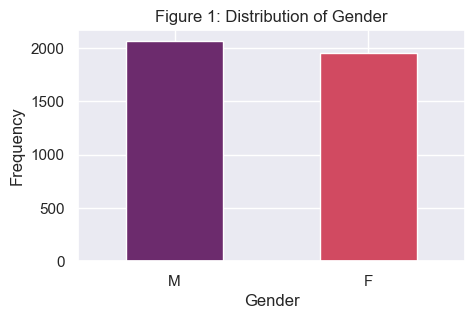

In [21]:
plt.figure(figsize=(5,3))
gender_counts.plot(kind='bar', title='Figure 1: Distribution of Gender', xlabel='Gender', ylabel='Frequency',
                   rot=0, color=[palette[-1], palette[-4]])
plt.show()

#### Alcoholism

In [22]:
# Distribution of comorbidity index
alc_counts = df_clean['alcoholism'].value_counts()
alc_counts

alcoholism
0    274
1     68
Name: count, dtype: int64

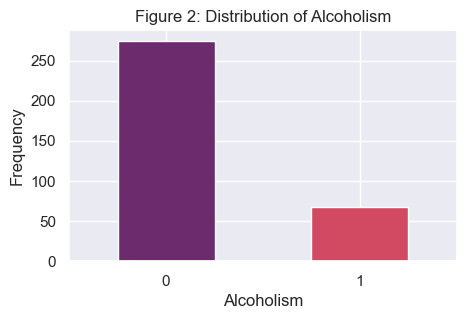

In [23]:
plt.figure(figsize=(5,3))
alc_counts.plot(kind='bar', title='Figure 2: Distribution of Alcoholism', xlabel='Alcoholism', ylabel='Frequency',
                   rot=0, color=[palette[-1], palette[-4]])
plt.show()

#### Anchor age

In [24]:
# Group age by 10 years
bins = list(range(20, 101, 10))
age_groups = pd.cut(df_clean['anchor_age'], bins=bins, right=False)
ageg_counts = age_groups.value_counts().sort_index()

# Grouped age counts
print(ageg_counts)

anchor_age
[20, 30)     16
[30, 40)     34
[40, 50)     55
[50, 60)     74
[60, 70)     63
[70, 80)     52
[80, 90)     42
[90, 100)     6
Name: count, dtype: int64


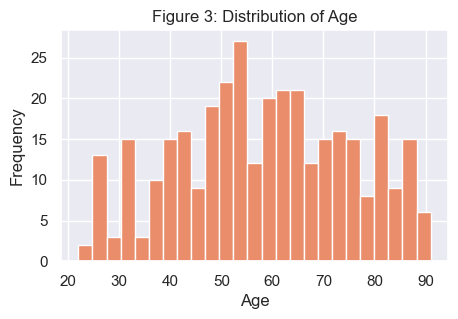

In [25]:
plt.figure(figsize=(5,3))
df_clean['anchor_age'].plot(kind='hist', title='Figure 3: Distribution of Age',ylabel='Frequency',
                      rot=0, bins=25).set_xlabel('Age')
plt.show()

#### Date of death

In [26]:
# Distribution of date of death
dod_counts = df['deathtime'].value_counts(dropna=False)
dod_counts[:10]

deathtime
NaN                    3919
2155-04-03T15:52:00       1
2161-09-08T18:40:00       1
2181-12-01T16:19:00       1
2118-07-07T01:40:00       1
2127-04-28T11:17:00       1
2177-09-30T19:55:00       1
2141-09-22T12:05:00       1
2154-07-01T20:11:00       1
2179-04-14T16:00:00       1
Name: count, dtype: int64

In [27]:
print("Number of patients survived is", len(df[df.mortality == 'Survive']))
print(f"Mortality rate is {round(100* len(df[df.mortality == 'Dead']) / len(df),2)}%")

Number of patients survived is 3919
Mortality rate is 2.44%


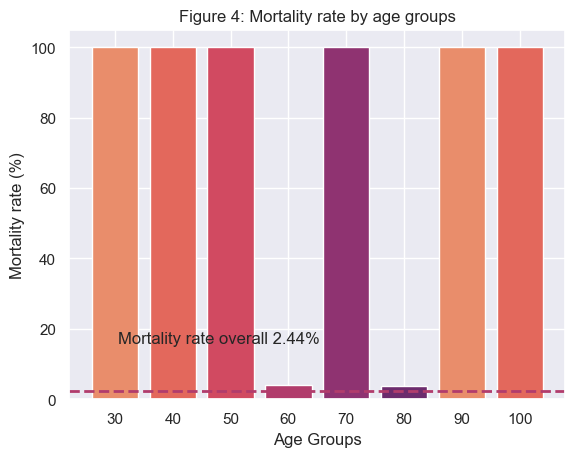

In [28]:
# Mortality rate in each age groups
rate_age = pd.DataFrame(zip(df['mortality'], age_groups), columns=['mortality', 'age_groups'])
total = rate_age.groupby(['age_groups']).count()
rate = pd.DataFrame(rate_age.groupby(['age_groups', 'mortality']).size()).reset_index().drop_duplicates(subset=['age_groups'], keep="first")
mortality_rate = 100 * rate.iloc[:,2].values / total.values[:,0]

plt.bar(["30", "40", "50", "60", "70", "80", "90", "100"], mortality_rate, color=palette)
plt.axhline(y=round(100* len(df[df.mortality == 'Dead']) / len(df),2), color=palette[3], linestyle='--', linewidth=2, label='Mortality rate')
plt.annotate('Mortality rate overall 2.44%', xy=(0, 20), xytext=(0.05, 16))

plt.xlabel("Age Groups")
plt.ylabel("Mortality rate (%)")
plt.title("Figure 4: Mortality rate by age groups")

plt.show()

#### Others

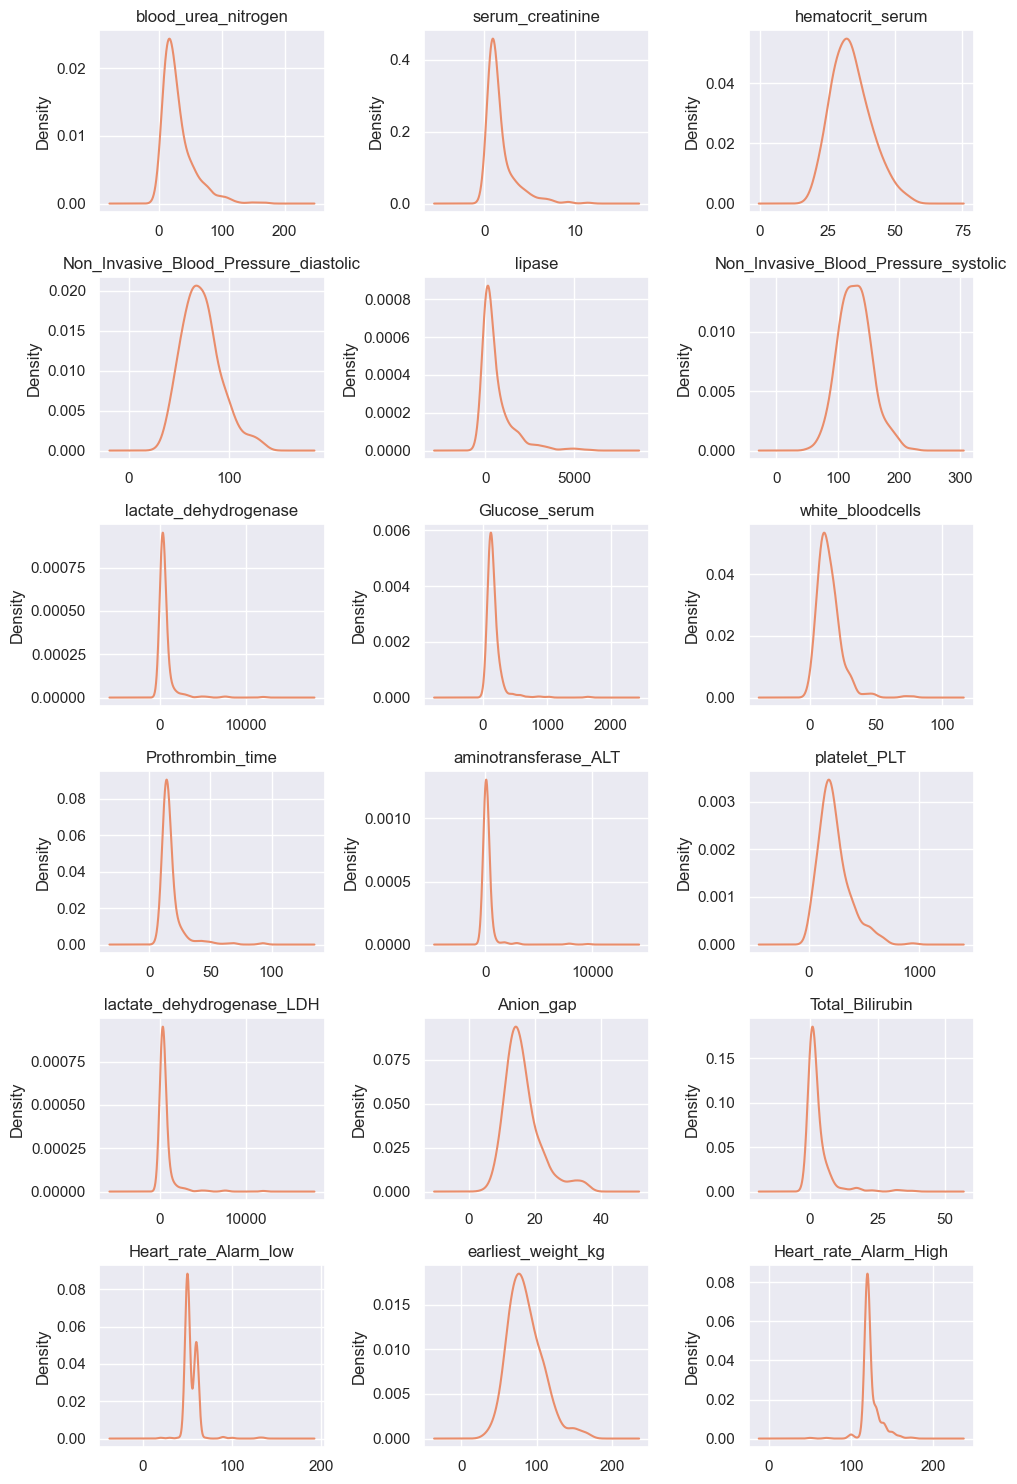

In [29]:
fig, axes = plt.subplots(6,3, figsize=(10,15))

for i, col in enumerate(features_kde):
    df_clean[col].plot(ax=axes[i//3, i%3-1], kind='kde', title=col)
    
plt.tight_layout()
plt.show()

## 3.3. Multivariate analysis

#### Helper function

In [30]:
"""
Plots histogram and boxplot to compare difference in distribution of given label
- label: the feature to be compared
- title: title of the figure
"""
def plot_mean_difference(df, label, title, colours):
    fig, axes = plt.subplots(2, len(features_kde), figsize=(30, 7))
    value = df[label].unique()
    p_vals = []

    for i in range(len(features_kde)):
        feature = features_kde[i]
        for j, val in enumerate(df[label].unique()):
            sns.kdeplot(df[df[label] == val][feature], ax=axes[0, i], fill=True, label=val, color=colours[j])
        axes[0, i].set(ylabel=None)
        axes[0, i].set(xlabel=None)
        axes[0, i].set_title(feature)

        sns.boxplot(ax=axes[1, i], x=label, y=feature, data=df, palette=colours)
        axes[1, i].set(ylabel=None)
        axes[1, i].set(xlabel=None)
        
        t_statistic, p_value = ttest_ind(df[df[label] == value[0]][feature].dropna(),
                                 df[df[label] == value[1]][feature].dropna())
        p_vals.append(p_value)
    axes[0,-1].legend(title=label)

    fig.suptitle(title)
    plt.show()
    return dict(zip(features_kde, p_vals))

"""
Plot coefficient correlation inside a pair plot, used in pair_plot function
"""
def reg_coef(x,y,label=None,color=None,hue=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    marker_size = abs(r) * 10000
    ax.scatter([.5], [.5], marker_size, [r], alpha=0.6, cmap="flare",
            vmin=-1, vmax=1, transform=ax.transAxes)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

"""
Plot pair grid of bivariate analysis, includes scatter plot and correlation computation
- df: dataframe containing all features
- label: the feature to be compared
- title: title of figure
"""
def pair_plot(df, label, title, colours):
    g = sns.PairGrid(df, hue=label, diag_sharey=False, palette=colours)
    g.map_upper(reg_coef, hue=None)
    g.map_diag(sns.kdeplot, fill=True)
    g.map_lower(sns.scatterplot)

    g.add_legend(adjust_subtitles=True, title=label)
    g.fig.subplots_adjust(top=0.95)
    g.fig.suptitle(title)

    plt.show()

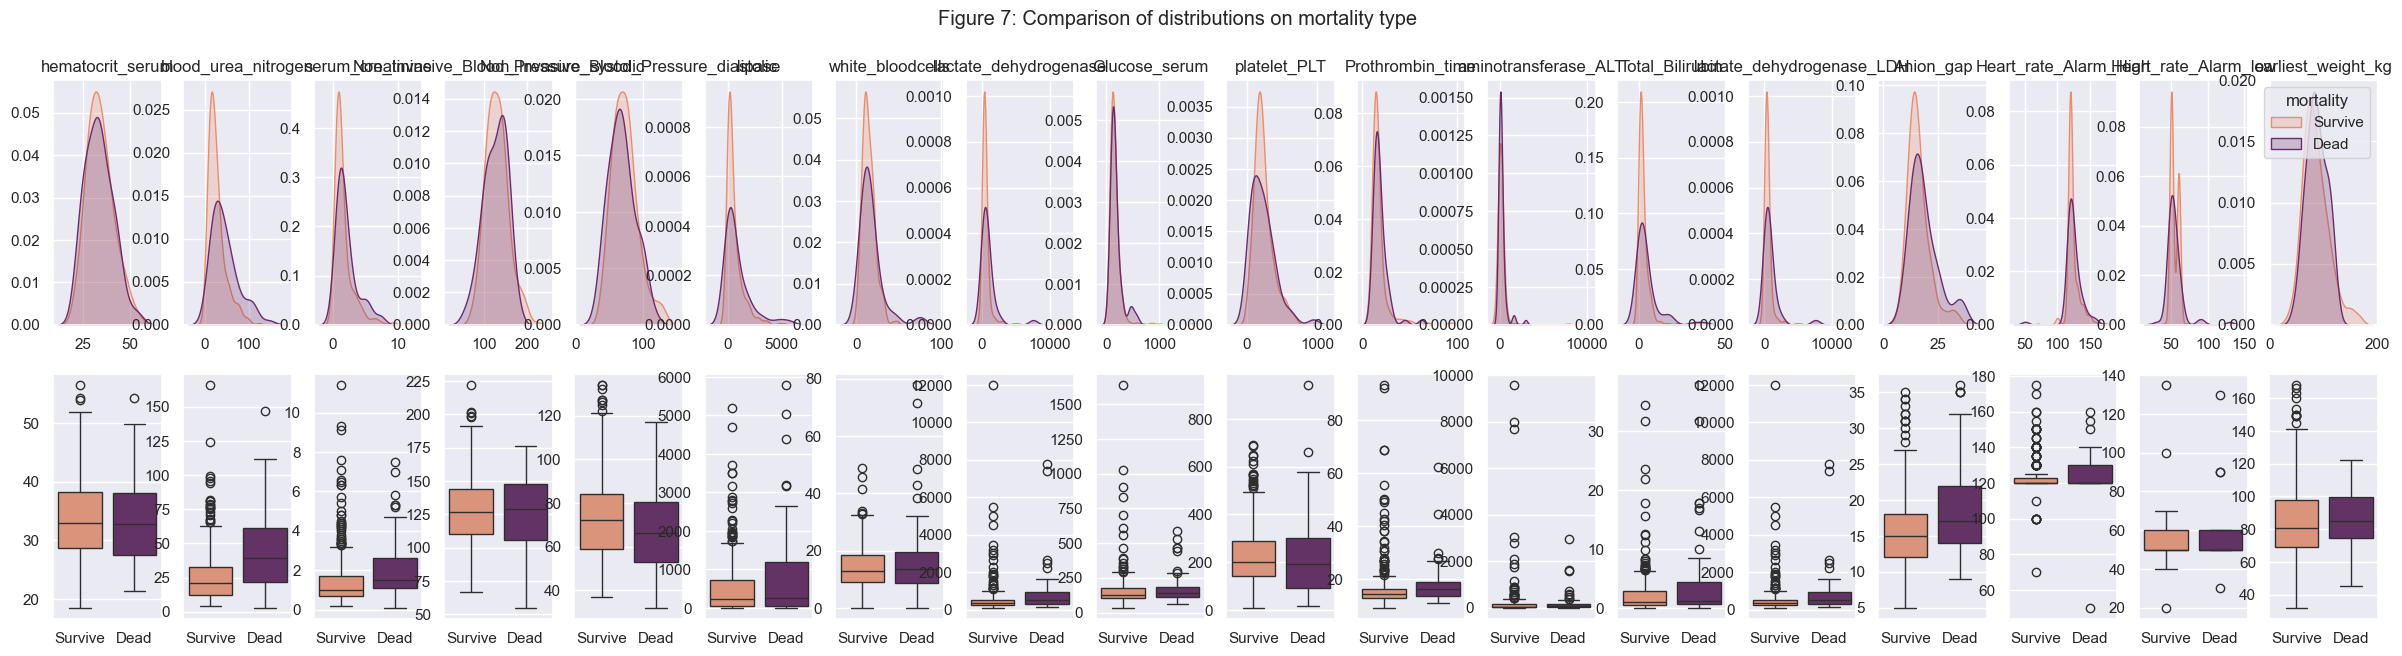

{'hematocrit_serum': 0.5526137677955539,
 'blood_urea_nitrogen': 2.9642799410394634e-07,
 'serum_creatinine': 0.03824012379978375,
 'Non_Invasive_Blood_Pressure_systolic': 0.3914932358579263,
 'Non_Invasive_Blood_Pressure_diastolic': 0.10363542478371705,
 'lipase': 0.025421245910064078,
 'white_bloodcells': 0.04119483440051762,
 'lactate_dehydrogenase': 0.02970784534333431,
 'Glucose_serum': 0.5649401070461426,
 'platelet_PLT': 0.7040561258480642,
 'Prothrombin_time': 0.5106219934256833,
 'aminotransferase_ALT': 0.8636917552054507,
 'Total_Bilirubin': 0.0030537829960548026,
 'lactate_dehydrogenase_LDH': 0.02970784534333431,
 'Anion_gap': 0.001143634376160871,
 'Heart_rate_Alarm_High': 0.7509142951424213,
 'Heart_rate_Alarm_low': 0.7623524145345795,
 'earliest_weight_kg': 0.7006988023838291}

In [31]:
plot_mean_difference(df_clean, 'mortality', "Figure 7: Comparison of distributions on mortality type", [palette[0], palette[-1]])

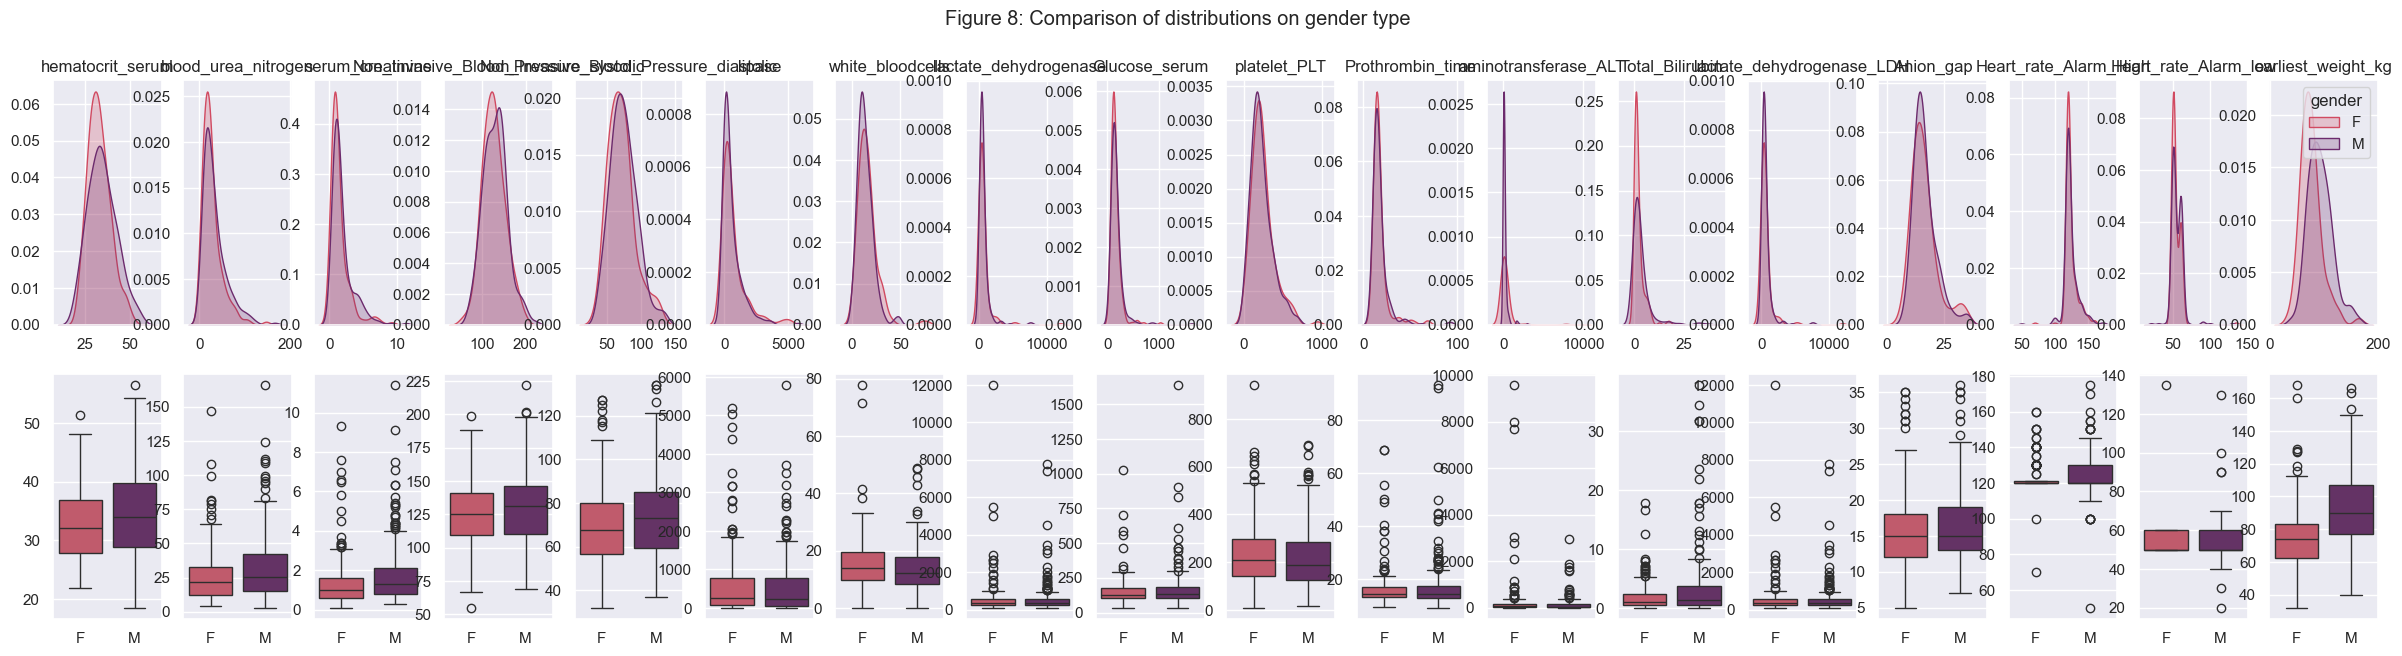

{'hematocrit_serum': 0.03032342505133045,
 'blood_urea_nitrogen': 0.027055402622389816,
 'serum_creatinine': 0.03127451531612103,
 'Non_Invasive_Blood_Pressure_systolic': 0.23842931762155367,
 'Non_Invasive_Blood_Pressure_diastolic': 0.10678333178954018,
 'lipase': 0.20109529282537855,
 'white_bloodcells': 0.03713192289409943,
 'lactate_dehydrogenase': 0.84861451225677,
 'Glucose_serum': 0.38639342301115376,
 'platelet_PLT': 0.2667433259633859,
 'Prothrombin_time': 0.9314458536520174,
 'aminotransferase_ALT': 0.03706778450458616,
 'Total_Bilirubin': 0.014058798921215802,
 'lactate_dehydrogenase_LDH': 0.84861451225677,
 'Anion_gap': 0.538827435081625,
 'Heart_rate_Alarm_High': 0.8490503891059138,
 'Heart_rate_Alarm_low': 0.19494042813068158,
 'earliest_weight_kg': 1.7061589983775018e-11}

In [32]:
plot_mean_difference(df_clean, 'gender', "Figure 8: Comparison of distributions on gender type", [palette[-4], palette[-1]])

# 4. Preprocessing

In [33]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   hadm_id                                342 non-null    int64  
 1   alcoholism                             342 non-null    int64  
 2   gender                                 342 non-null    object 
 3   anchor_age                             342 non-null    int64  
 4   hematocrit_serum                       342 non-null    float64
 5   blood_urea_nitrogen                    342 non-null    float64
 6   serum_creatinine                       342 non-null    float64
 7   Non_Invasive_Blood_Pressure_systolic   342 non-null    float64
 8   Non_Invasive_Blood_Pressure_diastolic  342 non-null    float64
 9   lipase                                 341 non-null    float64
 10  white_bloodcells                       342 non-null    float64
 11  lactat

In [34]:
# Drop gender
X = df_clean.drop(['hadm_id', 'gender', 'mortality'], axis=1)
X.head()

,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,lactate_dehydrogenase,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,lactate_dehydrogenase_LDH,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
0,1,46,36.4,37.0,1.2,117.0,58.0,727.0,13.6,220.0,178.0,220.0,9.8,20.0,0.6,220.0,20.0,140.0,60.0,78.0
1,1,45,43.5,7.0,1.1,151.0,109.0,723.0,14.5,420.0,288.0,136.0,15.0,31.0,0.6,420.0,34.0,120.0,50.0,65.0
2,0,54,33.6,7.0,0.7,124.0,75.0,24.0,17.5,164.0,202.0,178.0,15.8,32.0,0.3,164.0,12.0,120.0,50.0,160.4
3,0,76,34.3,51.0,4.8,124.0,110.0,779.0,33.7,409.0,215.0,117.0,15.6,222.0,4.0,409.0,20.0,120.0,60.0,94.5
4,0,86,26.4,33.0,1.5,105.0,51.0,830.0,7.9,1996.0,119.0,83.0,13.8,1896.0,2.2,1996.0,9.0,100.0,60.0,70.0


In [35]:
X['gender'] = LabelEncoder().fit_transform(df_clean['gender'])
X['mortality'] = LabelEncoder().fit_transform(df_clean['mortality'])
X.head()

,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,lactate_dehydrogenase,...,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,lactate_dehydrogenase_LDH,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,gender,mortality
0,1,46,36.4,37.0,1.2,117.0,58.0,727.0,13.6,220.0,...,9.8,20.0,0.6,220.0,20.0,140.0,60.0,78.0,0,1
1,1,45,43.5,7.0,1.1,151.0,109.0,723.0,14.5,420.0,...,15.0,31.0,0.6,420.0,34.0,120.0,50.0,65.0,0,1
2,0,54,33.6,7.0,0.7,124.0,75.0,24.0,17.5,164.0,...,15.8,32.0,0.3,164.0,12.0,120.0,50.0,160.4,0,1
3,0,76,34.3,51.0,4.8,124.0,110.0,779.0,33.7,409.0,...,15.6,222.0,4.0,409.0,20.0,120.0,60.0,94.5,1,1
4,0,86,26.4,33.0,1.5,105.0,51.0,830.0,7.9,1996.0,...,13.8,1896.0,2.2,1996.0,9.0,100.0,60.0,70.0,1,1


In [36]:
X = X.fillna(X.median())

In [37]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 2.00733947, -0.73521242,  0.35979222, ..., -0.32455259,
        -1.17260394,  0.45659672],
       [ 2.00733947, -0.79405694,  1.34009685, ..., -0.88267156,
        -1.17260394,  0.45659672],
       [-0.49817184, -0.26445623, -0.02680678, ...,  3.21306307,
        -1.17260394,  0.45659672],
       ...,
       [-0.49817184, -1.38250218,  0.53928462, ..., -0.58214596,
         0.85280287,  0.45659672],
       [-0.49817184, -0.4409898 , -0.22010628, ..., -0.28591358,
         0.85280287,  0.45659672],
       [-0.49817184,  0.50052257,  2.32040147, ...,  0.55555811,
         0.85280287,  0.45659672]])

One of the feature of standard scaling is that, we can detect outliers by filtering values `abs(x) > 3.5`. We choose number `3.5` as it does not discard huge amount of data while still being reasonable number for an outlier.

In [38]:
# Outliers detection for each features
X_cleaned = pd.DataFrame(X_scaled)
X_cleaned = X_scaled[(np.abs(X_scaled) < 3.5).all(axis=1)]
df_clean = df_clean[(np.abs(X_scaled) < 3.5).all(axis=1)]
print("Number of cleaned record is", len(X_cleaned))
X_cleaned

Number of cleaned record is 296


array([[ 2.00733947, -0.73521242,  0.35979222, ..., -0.32455259,
        -1.17260394,  0.45659672],
       [ 2.00733947, -0.79405694,  1.34009685, ..., -0.88267156,
        -1.17260394,  0.45659672],
       [-0.49817184, -0.26445623, -0.02680678, ...,  3.21306307,
        -1.17260394,  0.45659672],
       ...,
       [-0.49817184,  0.97127875, -0.38579157, ..., -0.53921373,
        -1.17260394,  0.45659672],
       [-0.49817184, -1.38250218,  0.53928462, ..., -0.58214596,
         0.85280287,  0.45659672],
       [-0.49817184, -0.4409898 , -0.22010628, ..., -0.28591358,
         0.85280287,  0.45659672]])

# 5. Clustering


## 5.1. Finding optimal cluster

Firstly, we try the clustering on non-cleaned dataset.

In [39]:
wcss = []
ss = []

# Run algorithm through different number of clusters
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i, random_state=RANDOM_STATE)
    kmeans.fit(X_scaled)

    # Record within cluster sum of squares
    wcss.append(kmeans.inertia_)

    # Record silhouette score
    sil_score = silhouette_score(X_scaled, kmeans.labels_)
    ss.append(sil_score)

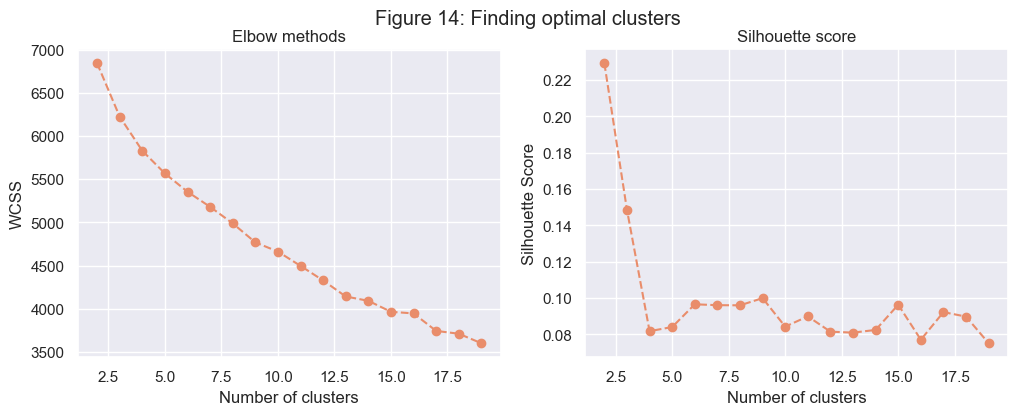

In [40]:
# Plot Elbow graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2, 20), wcss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow methods')

# Plot Silhouette Score graph
plt.subplot(1, 2, 2)
plt.plot(range(2, 20), ss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette score')

plt.suptitle("Figure 14: Finding optimal clusters")
plt.show()

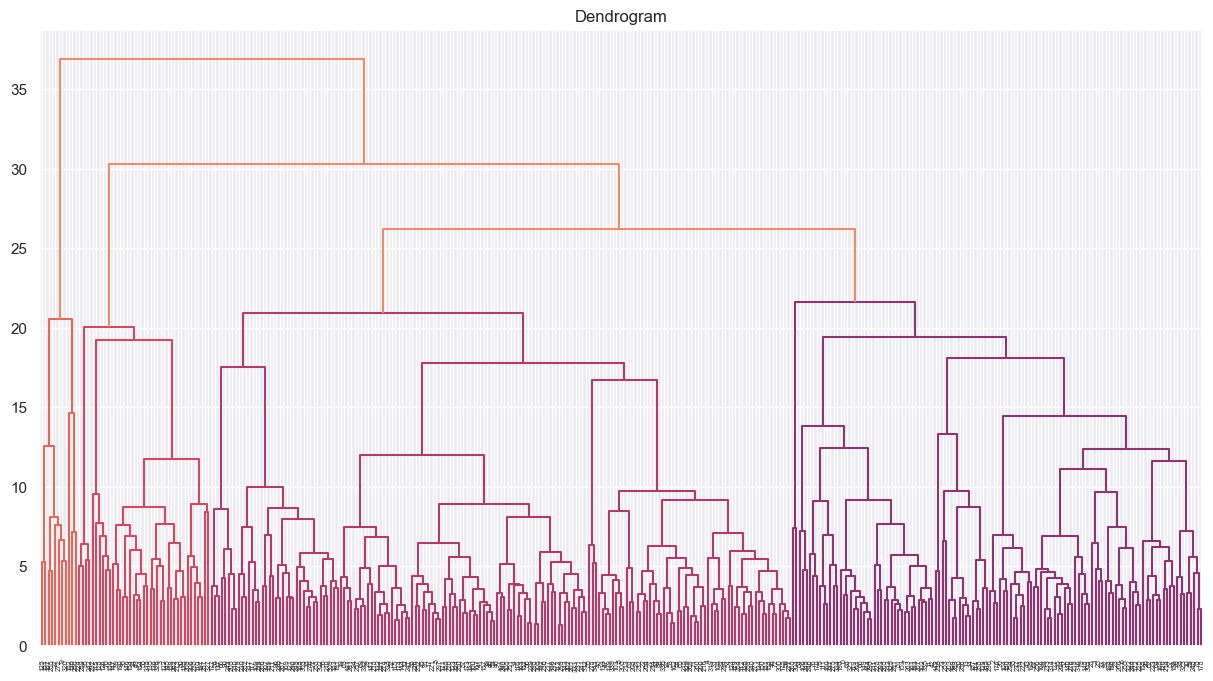

In [41]:
plt.figure(figsize=(15,8))

dendrogram = sch.dendrogram(sch.linkage(X_scaled, method  = "ward"))
plt.title('Dendrogram')
plt.show()

To further analyse the effect of outliers in the dataset, we perform clustering on cleaned dataset.

In [42]:
wcss = []
ss = []

# Run algorithm through different number of clusters
for i in range(2, 15):
    kmeans = KMeans(n_clusters=i, random_state=RANDOM_STATE)
    kmeans.fit(X_cleaned)

    # Record within cluster sum of squares
    wcss.append(kmeans.inertia_)

    # Record silhouette score
    sil_score = silhouette_score(X_cleaned, kmeans.labels_)
    ss.append(sil_score)

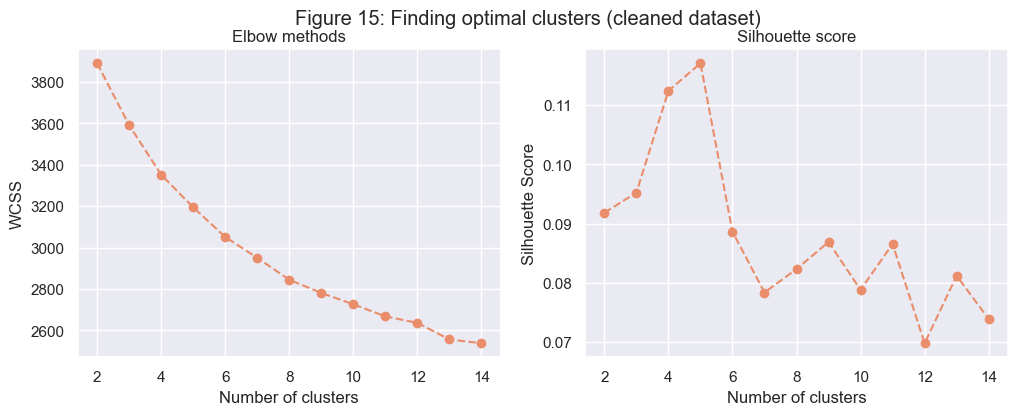

In [43]:
# Plot Elbow graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2, 15), wcss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow methods')

# Plot Silhouette Score graph
plt.subplot(1, 2, 2)
plt.plot(range(2, 15), ss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette score')

plt.suptitle("Figure 15: Finding optimal clusters (cleaned dataset)")
plt.show()

From Figure 15, we obtain that the best cluster to use on cleaned dataset is $4$. By removing high values (outliers) on the dataset contributes changes to the evaluation metrics and make the clusters more visible, achieving smaller WCSS and silhouette scores.

From this analysis, we can conclude that $3$ is the optimal cluster.

In [68]:
optimal_cluster = 5

## 5.2. Fitting the model

In [69]:
# Fit model
kmeans = KMeans(n_clusters=optimal_cluster, random_state=RANDOM_STATE)
kmeans.fit(X_cleaned)

df_clean['cluster'] = kmeans.labels_.astype(object)
df_clean.head()

,hadm_id,alcoholism,gender,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,...,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,lactate_dehydrogenase_LDH,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,mortality,cluster
0,22540021,1,F,46,36.4,37.0,1.2,117.0,58.0,727.0,...,9.8,20.0,0.6,220.0,20.0,140.0,60.0,78.0,Survive,4
1,20561449,1,F,45,43.5,7.0,1.1,151.0,109.0,723.0,...,15.0,31.0,0.6,420.0,34.0,120.0,50.0,65.0,Survive,4
2,25384874,0,F,54,33.6,7.0,0.7,124.0,75.0,24.0,...,15.8,32.0,0.3,164.0,12.0,120.0,50.0,160.4,Survive,2
3,24096764,0,M,76,34.3,51.0,4.8,124.0,110.0,779.0,...,15.6,222.0,4.0,409.0,20.0,120.0,60.0,94.5,Survive,3
4,23237185,0,M,86,26.4,33.0,1.5,105.0,51.0,830.0,...,13.8,1896.0,2.2,1996.0,9.0,100.0,60.0,70.0,Survive,1


In [70]:
# Evaluation metric
wcss = kmeans.inertia_
ss = silhouette_score(X_cleaned, kmeans.labels_)

print(f"Fitting model with {optimal_cluster} clusters, resulting on {round(wcss,2)} WCSS and {round(ss,2)} silhouette score")

Fitting model with 5 clusters, resulting on 3194.73 WCSS and 0.12 silhouette score


In [71]:
# Center of clusters
kmeans_center = scaler.inverse_transform(kmeans.cluster_centers_)
pd.DataFrame(dict(zip(df_clean.columns, kmeans_center.T)))

,hadm_id,alcoholism,gender,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,...,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,lactate_dehydrogenase_LDH,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
0,6.250000e-02,71.687500,32.525000,33.250000,1.334375,127.406250,71.062500,470.000000,13.715625,574.500000,...,16.181250,167.343750,3.350000,574.500000,16.406250,126.093750,52.187500,80.843750,0.562500,1.110223e-16
1,5.551115e-17,62.470588,31.302521,21.142857,1.059664,120.705882,66.302521,399.428571,13.170588,364.697479,...,16.042857,137.865546,2.126891,364.697479,13.689076,122.226891,53.487395,77.078992,0.411765,1.000000e+00
2,3.389831e-02,52.101695,40.571186,21.711864,1.144068,150.661017,89.881356,849.338983,16.754237,660.796610,...,17.330508,254.288136,1.906780,660.796610,15.983051,125.000000,54.576271,100.647458,0.711864,9.830508e-01
3,1.891892e-01,64.729730,34.945946,68.729730,4.151351,117.081081,59.135135,647.216216,15.356757,575.945946,...,16.010811,98.459459,1.981081,575.945946,20.351351,122.162162,52.837838,92.418919,0.756757,7.567568e-01
4,1.000000e+00,44.000000,32.442857,16.959184,1.006122,130.571429,79.734694,424.632653,12.038776,495.755102,...,14.791837,116.877551,3.191837,495.755102,15.183673,124.183673,53.877551,85.824490,0.673469,9.795918e-01


## 5.3. Visualization

### Clusters Visualization

In [72]:
cluster_colors = [palette[0], palette[2], palette[4], palette[-1], palette[-2]]

In [73]:
def stat_cum(cluster):
    cluster0 = df_clean[df_clean.cluster == cluster]
    print(f"Percentage of women and men (respectively) {round(100 * sum(cluster0.gender == 'F') / len(cluster0),2)} and {round(100 * sum(cluster0.gender == 'M') / len(cluster0),2)}")
    display(round(cluster0.describe(),2))

stat_cum(0)

Percentage of women and men (respectively) 43.75 and 56.25


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,lactate_dehydrogenase_LDH,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
count,32.00,32.00,32.00,32.00,32.00,32.00,32.00,32.00,32.00,32.00,...,32.00,32.00,31.00,32.00,32.00,32.00,32.00,32.00,32.00,32.00
mean,24812789.56,0.06,71.69,32.53,33.25,1.33,127.41,71.06,470.00,13.72,...,163.03,208.19,16.23,167.34,3.35,574.50,16.41,126.09,52.19,80.84
std,2772375.97,0.25,14.01,6.56,16.95,0.59,27.69,18.52,702.73,8.60,...,98.42,126.89,3.77,308.91,4.28,513.28,4.24,8.87,6.08,17.77
min,20497650.00,0.00,38.00,21.30,8.00,0.50,55.00,32.00,10.00,0.10,...,72.00,17.00,11.40,11.00,0.30,144.00,9.00,120.00,30.00,45.00
25%,22375633.00,0.00,62.00,27.68,19.00,0.98,110.75,63.75,41.50,6.95,...,111.50,106.75,13.75,31.75,0.90,242.75,13.75,120.00,50.00,66.35
50%,24420222.00,0.00,74.00,32.65,29.00,1.25,136.00,70.50,78.50,12.65,...,140.00,204.50,15.00,49.50,1.65,392.00,15.50,120.00,50.00,81.80
75%,27209730.25,0.00,85.25,36.60,43.00,1.60,147.50,80.25,500.75,18.22,...,181.50,308.00,17.95,143.75,4.00,653.50,18.00,130.00,60.00,92.50
max,29736524.00,1.00,91.00,45.40,69.00,2.80,176.00,117.00,2651.00,38.20,...,532.00,447.00,27.70,1598.00,17.80,2630.00,28.00,155.00,60.00,118.60


In [74]:
# Statistical summary of cluster 1
stat_cum(1)

Percentage of women and men (respectively) 58.82 and 41.18


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,lactate_dehydrogenase_LDH,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
count,119.00,119.0,119.00,119.00,119.00,119.00,119.00,119.00,118.00,119.00,...,119.00,119.00,118.00,119.00,119.00,118.00,119.00,119.00,119.00,119.00
mean,24721660.86,0.0,62.47,31.30,21.14,1.06,120.71,66.30,400.90,13.17,...,134.41,239.45,16.06,137.87,2.13,364.83,13.69,122.23,53.49,77.08
std,3019318.62,0.0,16.63,5.23,12.63,0.61,22.57,13.68,597.18,7.14,...,65.32,124.28,5.55,235.72,2.30,303.66,3.70,8.35,4.76,17.90
min,20101858.00,0.0,22.00,18.50,4.00,0.20,76.00,37.00,6.00,0.10,...,46.00,10.00,9.40,2.00,0.20,102.00,5.00,100.00,50.00,32.00
25%,22106113.50,0.0,52.00,27.35,12.00,0.60,104.00,57.00,34.50,8.05,...,100.50,157.50,13.10,21.50,0.60,200.25,11.50,120.00,50.00,64.10
50%,24638045.00,0.0,63.00,31.30,18.00,0.90,119.00,66.00,151.00,11.70,...,115.00,218.00,14.35,55.00,1.10,268.50,14.00,120.00,50.00,75.00
75%,27320016.50,0.0,75.00,34.95,26.00,1.35,136.00,75.50,559.25,18.40,...,153.00,301.00,16.82,172.00,2.95,393.50,15.00,120.00,60.00,88.25
max,29956550.00,0.0,91.00,42.30,81.00,3.20,191.00,107.00,3516.00,33.10,...,560.00,622.00,45.10,1896.00,11.30,1996.00,30.00,160.00,60.00,129.20


In [75]:
# Statistical summary of cluster 2
stat_cum(2)

Percentage of women and men (respectively) 28.81 and 71.19


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,lactate_dehydrogenase_LDH,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
count,59.00,59.00,59.00,59.00,59.00,59.00,59.00,59.00,59.00,59.00,...,59.00,59.00,56.00,59.00,59.00,59.00,59.00,59.00,59.00,59.00
mean,24836894.22,0.03,52.10,40.57,21.71,1.14,150.66,89.88,849.34,16.75,...,164.90,229.54,17.48,254.29,1.91,660.80,15.98,125.00,54.58,100.65
std,2936561.72,0.18,15.45,7.43,12.45,0.52,24.20,17.81,911.84,7.57,...,73.85,130.79,7.86,567.93,2.12,739.92,3.55,9.38,5.36,28.15
min,20024364.00,0.00,25.00,23.20,5.00,0.40,100.00,58.00,17.00,0.10,...,73.00,17.00,10.00,6.00,0.20,109.00,9.00,120.00,50.00,49.50
25%,22385366.00,0.00,39.50,34.90,13.50,0.75,136.00,77.00,99.00,12.30,...,110.00,159.00,13.68,26.00,0.70,273.50,14.00,120.00,50.00,81.75
50%,24976204.00,0.00,52.00,39.70,18.00,1.00,148.00,87.00,604.00,15.90,...,150.00,202.00,14.85,60.00,1.10,423.00,15.00,120.00,50.00,97.80
75%,27427758.50,0.00,63.50,46.70,28.50,1.40,162.00,98.00,1279.50,21.75,...,195.50,280.50,16.27,212.00,2.15,659.50,17.00,130.00,60.00,114.15
max,29217706.00,1.00,86.00,56.50,79.00,3.00,202.00,132.00,3705.00,41.50,...,396.00,687.00,50.40,3030.00,12.40,3460.00,27.00,160.00,70.00,166.60


In [76]:
# Statistical summary of cluster 2
stat_cum(3)

Percentage of women and men (respectively) 24.32 and 75.68


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,lactate_dehydrogenase_LDH,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
count,37.00,37.00,37.00,37.00,37.00,37.00,37.00,37.00,37.00,37.00,...,37.00,37.00,36.00,37.00,37.00,37.00,37.00,37.00,37.00,37.00
mean,25001306.68,0.19,64.73,34.95,68.73,4.15,117.08,59.14,647.22,15.36,...,173.43,198.57,16.05,98.46,1.98,575.95,20.35,122.16,52.84,92.42
std,3082151.79,0.40,14.17,7.45,22.23,1.41,20.88,14.07,773.69,10.22,...,82.38,103.63,5.25,137.95,3.14,379.78,5.74,7.41,4.49,22.07
min,20286641.00,0.00,31.00,21.50,33.00,1.90,75.00,39.00,16.00,2.80,...,74.00,32.00,11.10,6.00,0.10,153.00,13.00,100.00,50.00,47.10
25%,22217701.00,0.00,55.00,29.80,53.00,3.10,105.00,48.00,99.00,8.60,...,118.00,136.00,13.28,23.00,0.40,308.00,17.00,120.00,50.00,78.00
50%,25124512.00,0.00,65.00,34.30,60.00,4.20,118.00,59.00,263.00,13.60,...,146.00,190.00,14.70,34.00,1.00,488.00,19.00,120.00,50.00,85.20
75%,28007037.00,0.00,76.00,40.10,83.00,5.20,129.00,67.00,870.00,19.80,...,215.00,248.00,16.02,90.00,1.80,588.00,22.00,120.00,60.00,113.00
max,29966638.00,1.00,91.00,51.30,110.00,7.10,167.00,110.00,3187.00,45.80,...,444.00,475.00,38.40,593.00,17.10,1611.00,35.00,150.00,60.00,145.00


In [77]:
# Statistical summary of cluster 2
stat_cum(4)

Percentage of women and men (respectively) 32.65 and 67.35


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,lactate_dehydrogenase_LDH,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
count,49.00,49.0,49.00,49.00,49.00,49.00,49.00,49.00,49.00,49.00,...,49.00,49.00,49.00,49.00,49.00,49.00,49.00,49.00,49.00,49.00
mean,25207731.67,1.0,44.00,32.44,16.96,1.01,130.57,79.73,424.63,12.04,...,143.76,237.78,14.79,116.88,3.19,495.76,15.18,124.18,53.88,85.82
std,2928641.65,0.0,9.64,6.37,10.61,0.65,23.73,20.34,595.25,5.68,...,59.44,170.68,4.04,305.35,4.13,350.02,4.99,8.06,5.33,20.24
min,20561449.00,1.0,25.00,20.70,3.00,0.20,73.00,39.00,13.00,2.50,...,66.00,28.00,9.80,9.00,0.20,131.00,8.00,120.00,40.00,45.40
25%,22694963.00,1.0,39.00,28.00,9.00,0.50,110.00,66.00,62.00,8.70,...,101.00,116.00,12.60,21.00,0.60,278.00,12.00,120.00,50.00,71.00
50%,25272169.00,1.0,44.00,32.00,13.00,0.80,131.00,78.00,221.00,11.60,...,124.00,187.00,13.70,36.00,1.80,411.00,14.00,120.00,50.00,81.20
75%,27969577.00,1.0,51.00,36.40,22.00,1.20,144.00,90.00,488.00,14.50,...,162.00,309.00,15.10,90.00,4.20,616.00,17.00,120.00,60.00,97.00
max,29961750.00,1.0,63.00,47.30,51.00,3.10,189.00,134.00,2808.00,26.70,...,288.00,690.00,34.20,2095.00,17.90,1801.00,34.00,150.00,60.00,150.00


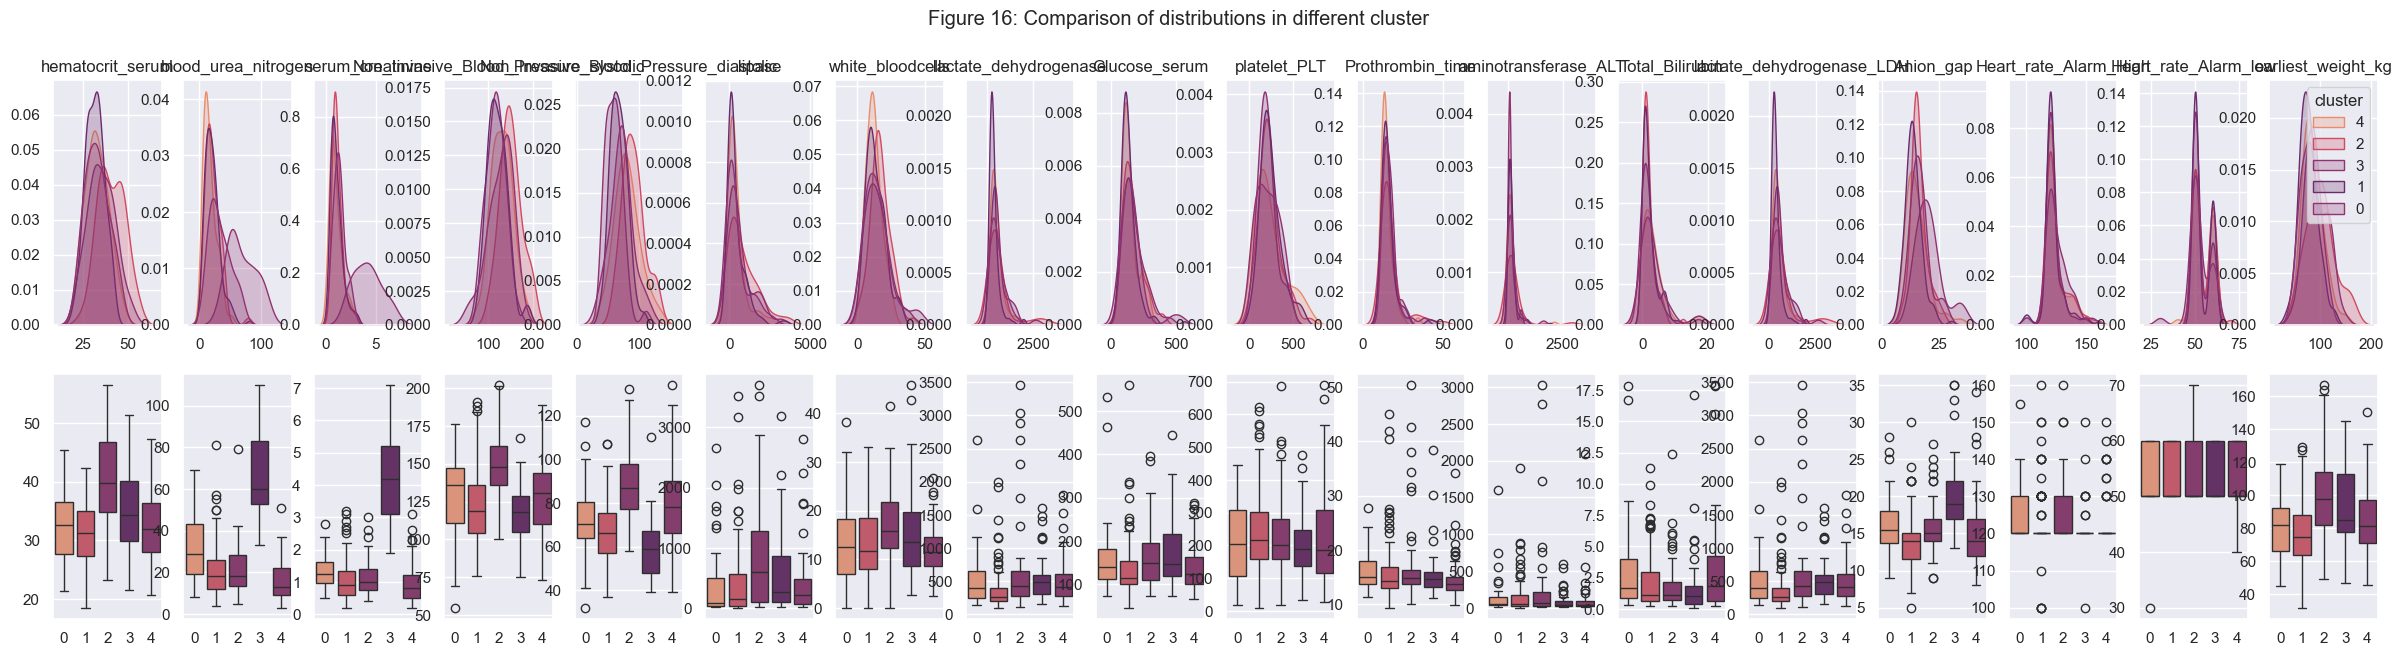

{'hematocrit_serum': 2.3652816618249e-08,
 'blood_urea_nitrogen': 0.03718599359801894,
 'serum_creatinine': 0.22477299553321248,
 'Non_Invasive_Blood_Pressure_systolic': 3.36497799124739e-05,
 'Non_Invasive_Blood_Pressure_diastolic': 0.006745180109682581,
 'lipase': 0.006055236512182616,
 'white_bloodcells': 0.0004877703298727878,
 'lactate_dehydrogenase': 0.15478173476196985,
 'Glucose_serum': 0.10912193175372997,
 'platelet_PLT': 0.77723048145596,
 'Prothrombin_time': 0.03350055355977326,
 'aminotransferase_ALT': 0.13143846234092912,
 'Total_Bilirubin': 0.03980274915220857,
 'lactate_dehydrogenase_LDH': 0.15478173476196985,
 'Anion_gap': 0.3339161798389533,
 'Heart_rate_Alarm_High': 0.6324341397166346,
 'Heart_rate_Alarm_low': 0.500249780908164,
 'earliest_weight_kg': 0.002617561892111957}

In [78]:
plot_mean_difference(df_clean, 'cluster', "Figure 16: Comparison of distributions in different cluster", colours=cluster_colors)

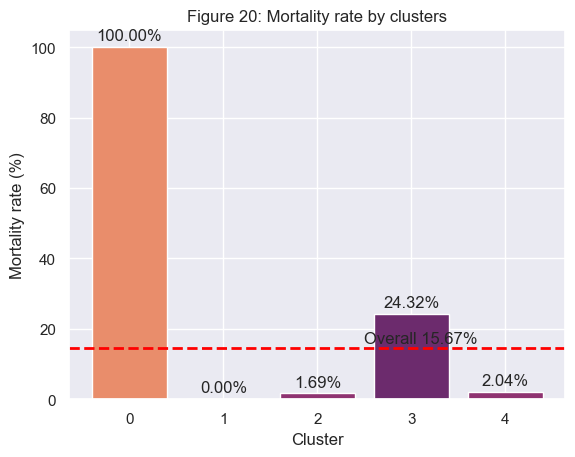

In [80]:
# Mortality rate in each cluster
mortality_cluster = []

for c in sorted(df_clean['cluster'].unique()):
    sub = df_clean[df_clean.cluster == c]
    mortality_cluster.append(100 * len(sub[sub.mortality == 'Dead']) / len(sub))

plt.bar(["0","1","2", "3", "4"], mortality_cluster, color=cluster_colors)
plt.axhline(y=round(100* len(df_clean[df_clean.mortality == 'Dead']) / len(df_clean),2), color='red', linestyle='--', linewidth=2, label='Mortality rate')
plt.annotate('Overall 15.67%', xy=(0, 20), xytext=(2.5, 16))

for i, rate in enumerate(mortality_cluster):
    plt.text(i, rate + 1, f'{rate:.2f}%', ha='center', va='bottom')

plt.xlabel("Cluster")
plt.ylabel("Mortality rate (%)")
plt.title("Figure 20: Mortality rate by clusters")

plt.show()

### On PCA

In [81]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame for visualization
X_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
X_pca['cluster'] = df_clean['cluster']
X_pca

,PC1,PC2,PC3,cluster
0,-0.544487,0.023690,0.020186,4
1,-0.019977,0.930426,2.283897,4
2,-1.560742,0.110213,0.204373,2
3,0.778212,-1.494059,1.625518,3
4,1.853315,0.844810,-2.130234,1
...,...,...,...,...
337,-0.112244,0.733117,-2.108150,4
338,-0.748238,0.093530,-0.730078,1
339,-0.196964,-0.436545,-0.552608,1
340,-0.785151,0.026351,-0.031900,1


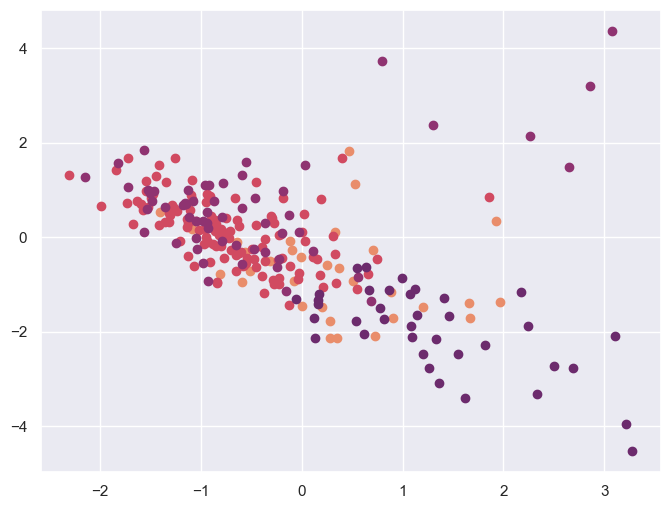

In [82]:
plt.figure(figsize=(8, 6))
for cluster in range(4):
    cluster_data = X_pca[X_pca['cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'cluster {cluster}', color=cluster_colors[cluster])

In [83]:
import plotly.express as px

fig = px.scatter_3d(X_pca, x='PC1', y='PC2', z='PC3',
              color='cluster', title="Figure 12: Age, Comorbidity Index, and APS-III", color_discrete_sequence=cluster_colors)
fig.show()

# 6. Discussion

## 6.1. Property of the clusters

## 6.2. Relation to Outcomes